# Predicting the Dow Jones with News

The goal of this project is to use the top, daily news headlines from Reddit to predict the movement of the Dow Jones Industrial Average. The data for this project spans from 2008-08-08 to 2016-07-01, and is from this [Kaggle dataset](https://www.kaggle.com/aaron7sun/stocknews). 

The news from a given day will be used to predict the difference in opening price between that day, and the following day. This method is chosen because it should allow all of the day's news to be incorporated into the price compared to closing price, which could only incorporate the day's morning and afternoon news.

For this project, we will use GloVe to create our word embeddings and CNNs followed by LSTMs to build our model. This model is based off the work done in this paper https://www.aclweb.org/anthology/C/C16/C16-1229.pdf.

In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

In [60]:
# # Fetch original data
# !wget https://raw.githubusercontent.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/master/DowJones.csv -O ../data/raw/DowJones.csv
# !wget https://raw.githubusercontent.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/master/News.csv -O ../data/raw/News.csv

In [61]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/quakumei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
dj = pd.read_csv("../data/raw/DowJones.csv")
news = pd.read_csv("../data/raw/News.csv")

## Inspect the data

In [63]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [64]:
dj.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [65]:
news.isnull().sum()

Date    0
News    0
dtype: int64

In [66]:
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [67]:
print(dj.shape)
print(news.shape)

(1989, 7)
(73608, 2)


In [68]:
# Compare the number of unique dates. We want matching values.
print(len(set(dj.Date)))
print(len(set(news.Date)))

1989
2943


In [69]:
# Remove the extra dates that are in news
news = news[news.Date.isin(dj.Date)]

In [70]:
print(len(set(dj.Date)))
print(len(set(news.Date)))

1989
1989


In [71]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict how much the Open value will change beased on the news.
dj = dj.set_index('Date').diff(periods=1)
dj['Date'] = dj.index
dj = dj.reset_index(drop=True)
# Remove unneeded features
dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)

/tmp/ipykernel_112380/3557597623.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)


In [72]:
dj.head()

,Open,Date
0,NaN,2016-07-01
1,-211.480468,2016-06-30
2,-256.740235,2016-06-29
3,-265.509765,2016-06-28
4,164.701172,2016-06-27


In [73]:
# Remove top row since it has a null value.
dj = dj[dj.Open.notnull()]

In [74]:
# Check if there are any more null values.
dj.isnull().sum()

Open    0
Date    0
dtype: int64

In [75]:
# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
headlines = []

for row in dj.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Open'])
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])
    
    # Track progress
    headlines.append(daily_headlines)
    if len(price) % 500 == 0:
        print(len(price))

500
1000
1500


In [176]:
print(f"max_price = {max(price)}\nmin_price = {min(price)}\nmean_price = {np.mean(price)}")

max_price = 768.0400389999995
min_price = -926.5498050000006
mean_price = -3.26566921026157


In [76]:
# Compare lengths to ensure they are the same
print(len(price))
print(len(headlines))

1988
1988


In [77]:
# Compare the number of headlines for each day
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))
print(np.mean([len(i) for i in headlines]))

25
22
24.996478873239436


In [78]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

In [79]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''

    # Convert words to lower case
    text = text.lower()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'0,0', '00', text)
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)

    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [80]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [175]:
# export clean_headlines to interim
import pickle
with open('../data/interim/clean_headlines.pkl', 'wb') as f:
    pickle.dump(clean_headlines, f)


In [81]:
# Take a look at some headlines to ensure everything was cleaned well
clean_headlines[0]

['jamaica proposes marijuana dispensers tourists airports following legalisation kiosks desks would give people license purchase 2 ounces drug use stay',
 'stephen hawking says pollution stupidity still biggest threats mankind certainly become less greedy less stupid treatment environment past decade',
 'boris johnson says run tory party leadership',
 'six gay men ivory coast abused forced flee homes pictured signing condolence book victims recent attack gay nightclub florida',
 'switzerland denies citizenship muslim immigrant girls refused swim boys report',
 'palestinian terrorist stabs israeli teen girl death bedroom',
 'puerto rico default $ 1 billion debt friday',
 'republic ireland fans awarded medal sportsmanship paris mayor',
 'afghan suicide bomber kills 40 bbc news',
 'us airstrikes kill least 250 isis fighters convoy outside fallujah official says',
 'turkish cop took istanbul gunman hailed hero',
 'cannabis compounds could treat alzheimer removing plaque forming proteins br

In [82]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1

print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 35190


In [83]:
# !!! Большой файл (5.6GB) !!! (+8GB total)
# !make -C ../ prepare_glove
# !unzip ../models/glove/glove840b300dtxt.zip -d ../models/glove/

In [84]:
# Load GloVe's embeddings
embeddings_index = {}
with open('../models/glove/glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196017


In [85]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 47
Percent of words that are missing from vocabulary: 0.13%


In [86]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 35190
Number of Words we will use: 31265
Percent of Words we will use: 88.85%


In [87]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

31265


Note: The embeddings will be updated as the model trains, so our new 'random' embeddings will be more accurate by the end of training. This is also why we want to only use words that appear at least 10 times. By having the model see the word numerous timesm it will be better able to understand what it means. 

In [88]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 615989
Total number of UNKs in headlines: 5262
Percent of words that are UNK: 0.8500000000000001%


In [89]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [90]:
lengths.describe()

,counts
count,49693.000000
mean,12.395891
std,6.790246
min,1.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,41.000000


In [91]:
# Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [92]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [93]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [94]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.5448422454901358


In [95]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [96]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1689
299


In [97]:
from keras.layers import concatenate
from keras.layers import Conv1D, Convolution1D

In [98]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True

if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2


def build_model():

    # model1 = Sequential()
    in1 = Input(shape=max_daily_length)
    out1 = Embedding(nb_words, embedding_dim, weights=[word_embedding_matrix], trainable=False, input_length=max_daily_length)(in1)
    out1 = Dropout(dropout)(out1)
    out1 = Conv1D(filters=nb_filter, kernel_size=filter_length1, padding='same', activation='relu')(out1)
    out1 = Dropout(dropout)(out1)
    if deeper == True:
        out1 = Conv1D(filters=nb_filter, kernel_size=filter_length1, padding='same', activation='relu')(out1)
        out1 = Dropout(dropout)(out1)
    out1 = LSTM(rnn_output_size, return_sequences=False, kernel_initializer=weights, dropout=dropout)(out1)

    """
    # model1.add(Embedding(nb_words, 
    #                      embedding_dim,
    #                      weights=[word_embedding_matrix], 
    #                      input_length=max_daily_length))
    # model1.add(Dropout(dropout))
    
    # model1.add(Convolution1D(filters = nb_filter, 
    #                          kernel_size = filter_length1, 
    #                          padding = 'same',
    #                         activation = 'relu'))
    # model1.add(Dropout(dropout))
    
    # if deeper == True:
    #     model1.add(Convolution1D(filters = nb_filter, 
    #                              kernel_size = filter_length1, 
    #                              padding = 'same',
    #                             activation = 'relu'))
    #     model1.add(Dropout(dropout))
    
    # model1.add(LSTM(rnn_output_size, 
    #                activation=None,
    #                kernel_initializer=weights,
    #                dropout = dropout))
    """
    ####

    in2 = Input(shape=max_daily_length)
    out2 = Embedding(nb_words, embedding_dim, weights=[word_embedding_matrix], trainable=False)(in2)
    out2 = Dropout(dropout)(out2)
    out2 = Conv1D(filters=nb_filter, kernel_size=filter_length2, padding='same', activation='relu')(out2)
    out2 = Dropout(dropout)(out2)
    if deeper == True:
        out2 = Conv1D(filters=nb_filter, kernel_size=filter_length2, padding='same', activation='relu')(out2)
        out2 = Dropout(dropout)(out2)
    out2 = LSTM(rnn_output_size, return_sequences=False, kernel_initializer=weights, dropout=dropout)(out2)

    """
    # model2 = Sequential()
    
    # model2.add(Embedding(nb_words, 
    #                      embedding_dim,
    #                      weights=[word_embedding_matrix], 
    #                      input_length=max_daily_length))
    # model2.add(Dropout(dropout))
    
    
    # model2.add(Convolution1D(filters = nb_filter, 
    #                          kernel_size = filter_length2, 
    #                          padding = 'same',
    #                          activation = 'relu'))
    # model2.add(Dropout(dropout))
    
    # if deeper == True:
    #     model2.add(Convolution1D(filters = nb_filter, 
    #                              kernel_size = filter_length2, 
    #                              padding = 'same',
    #                              activation = 'relu'))
    #     model2.add(Dropout(dropout))
    
    # model2.add(LSTM(rnn_output_size, 
    #                 activation=None,
    #                 kernel_initializer=weights,
    #                 dropout = dropout))
    
    ####

    # model = Sequential()

    # # model.add(Merge([model1, model2], mode='concat'))


    # # model1_out = model1.output
    # # model2_out = model2.output
    # # model1_in = model1.input
    # # model2_in = model2.input
    """

    # !!!: HERE
    out3 = Concatenate(-1)([out1, out2])
    out3 = Dense(hidden_dims, activation='relu', kernel_initializer=weights)(out3)
    out3 = Dropout(dropout)(out3)

    if deeper == True:
        out3 = Dense(hidden_dims // 2, activation='relu', kernel_initializer=weights)(out3)
        out3 = Dropout(dropout)(out3)

    out3 = Dense(1, kernel_initializer=weights, name='outputs')(out3)

    """
    # model.add(Dense(hidden_dims, kernel_initializer=weights))
    # model.add(Dropout(dropout))

    # if deeper == True:
    #     model.add(Dense(hidden_dims//2, kernel_initializer=weights))
    #     model.add(Dropout(dropout))

    # model.add(Dense(1,
    #                 kernel_initializer = weights,
    #                 name='output'))

    # model.compile(loss='mean_squared_error',
    #               optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    """

    model = Model(inputs=[in1, in2], outputs=out3)
    model.compile(loss='mean_squared_error',
                    optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    return model

In [99]:
# Use grid search to help find a better model
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(
                    deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)


Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3

Epoch 1/100


/home/quakumei/.conda/envs/py39/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 6s 229ms/step - loss: 0.1546 - val_loss: 0.0104 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 1s 90ms/step - loss: 0.0268 - val_loss: 0.0128 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 1s 90ms/step - loss: 0.0194 - val_loss: 0.0172 - lr: 0.0010
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0144
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
12/12 [==============================] - 1s 90ms/step - loss: 0.0144 - val_loss: 0.0155 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 1s 90ms/step - loss: 0.0143 - val_loss: 0.0169 - lr: 2.0000e-04
Epoch 6/100
12/12 [==============================] - 1s 91ms/step - loss: 0.0141 - val_loss: 0.0139 - lr: 2.0000e-04
Epoch 6: early stopping

Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.5

Epoch 1/100
12/12 [==============================] - 6s 236ms/step - loss: 0.1948 - val_loss: 0

In [133]:
# Make predictions with the best weights
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
# Need to rebuild model in case it is different from the model that was trained most recently.
model = build_model()

history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)
# get input layer shape
input_shape = model.layers[0].input_shape
print( input_shape )

model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))
predictions = model.predict([x_test,x_test], verbose = True)

Epoch 1/100


/home/quakumei/.conda/envs/py39/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 5s 156ms/step - loss: 0.1639 - val_loss: 0.0105 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 1s 81ms/step - loss: 0.0271 - val_loss: 0.0132 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 1s 82ms/step - loss: 0.0194 - val_loss: 0.0221 - lr: 0.0010
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0166
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
12/12 [==============================] - 1s 82ms/step - loss: 0.0165 - val_loss: 0.0221 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 1s 83ms/step - loss: 0.0150 - val_loss: 0.0146 - lr: 2.0000e-04
Epoch 6/100
12/12 [==============================] - 1s 84ms/step - loss: 0.0145 - val_loss: 0.0168 - lr: 2.0000e-04
Epoch 6: early stopping
[(None, 200)]
10/10 [==============================] - 1s 12ms/step


In [134]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.009450620092452474

In [141]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [142]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [172]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

96.36730982031258

In [138]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  299.000000
mean    -7.094101
std    139.532324
min   -541.050782
25%    -87.465332
50%    -10.759766
75%     54.689941
max    673.139648

Summary of predicted opening price changes
                 
count  299.000000
mean    -4.145324
std     87.435951
min   -213.541687
25%    -62.556519
50%     -6.308167
75%     51.882446
max    251.541626


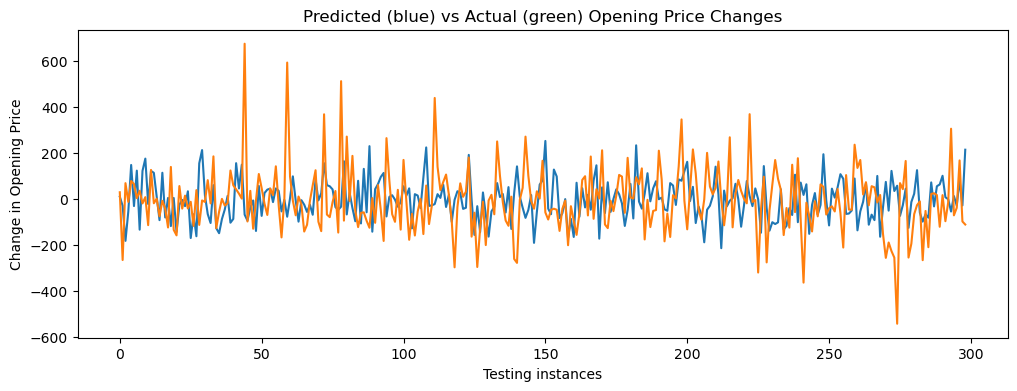

In [144]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [145]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [146]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 49.830000000000005% of the time.


As we can see from the data above, this model struggles to accurately predict the change in the opening price of the Dow Jones Instrustial Average. Given that its median average error is 74.15 and the interquartile range of the actual price change is 142.16 (87.47 + 54.69), this model is about as good as someone who knows the average price change of the Dow. 

I have a few ideas for why this model struggles:
- The market is arguably to be a random walk. Although there is some direction to its movements, there is still quite a bit of randomness to its movements.
- The news that we used might not be the most relevant. Perhaps it would have been better to use news relating to the 30 companies that make up the Dow.
- More information could have been included in the model, such as the previous day(s)'s change, the previous day(s)'s main headline(s). 
- Many people have worked on this task for years and companies spend millions of dollars to try to predict the movements of the market, so we shouldn't expect anything too great considering the small amount of data that we are working with and the simplicity of our model.

## Make Your Own Predictions

Below is the code necessary to make your own predictions. I found that the predictions are most accurate when there is no padding included in the input data. In the create_news variable, I have some default news that you can use, which is from April 30th, 2017. Just change the text to whatever you want, then see the impact your new headline will have.

In [147]:
def news_to_int(news):
    '''Convert your created news into integers'''
    ints = []
    for word in news.split():
        if word in vocab_to_int:
            ints.append(vocab_to_int[word])
        else:
            ints.append(vocab_to_int['<UNK>'])
    return ints

In [148]:
def padding_news(news):
    '''Adjusts the length of your created news to fit the model's input values.'''
    padded_news = news
    if len(padded_news) < max_daily_length:
        for i in range(max_daily_length-len(padded_news)):
            padded_news.append(vocab_to_int["<PAD>"])
    elif len(padded_news) > max_daily_length:
        padded_news = padded_news[:max_daily_length]
    return padded_news

In [177]:
# Default news that you can use
# create_news = "Middle Powers are reshaping geopolitics  \
#                Tracking Russia’s invasion of Ukraine in maps \
#                               Tracking Russia’s invasion of Ukraine in maps \
#                ‘We hit them with slingshots’: Ukraine’s ‘iron general’ shows his mettle\
#                Three found guilty of murder over roles in downing of flight MH17 \
#                Ukraine and western allies at odds over missile that hit Poland  \
#                Russia’s economy enters recession with 4% contraction  \
#                China playing ‘long game’ as it co-opts UK assets, warns MI5 chief \
#                Military briefing: how the battlefield will shift after Russia’s Kherson retreat \
#                Russia launches new missile barrage against Ukraine \
#                 DJ EXPERIENCES LOWEST LOW IN HISTORY"
# create_news = "U.S.-led fight on ISIS have killed 352 civilians: Pentagon \
#     Woman offers undercover officer sex for $25 and some Chicken McNuggets \
#     Ohio bridge refuses to fall down after three implosion attempts \
#     Jersey Shore MIT grad dies in prank falling from library dome \
#     New York graffiti artists claim McDonald's stole work for latest burger campaign \
#     SpaceX to launch secretive satellite for U.S. intelligence agency \
#     Severe Storms Leave a Trail of Death and Destruction Through the U.S. \
#     Hamas thanks N. Korea for its support against ‘Israeli occupation’ \
#     Baker Police officer arrested for allegedly covering up details in shots fired investigation \
#     Miami doctor’s call to broker during baby’s delivery leads to $33.8 million judgment \
#     Minnesota man gets 15 years for shooting 5 Black Lives Matter protesters \
#     South Australian woman facing possible 25 years in Colombian prison for drug trafficking \
#     The Latest: Deal reached on funding government through Sept. \
#     Russia flaunts Arctic expansion with new military bases\
    "
create_news = "BAD NEWS: The U.S. economy is in a recession. " * 30

clean_news = clean_text(create_news)

int_news = news_to_int(clean_news)

pad_news = padding_news(int_news)

pad_news = np.array(pad_news).reshape((1,-1))

pred = model.predict([pad_news,pad_news])

price_change = unnormalize(pred)

print("The Dow should open: {} from the previous open.".format(np.round(price_change[0][0],2)))

1/1 [==============================] - 0s 27ms/step
The Dow should open: 96.04000091552734 from the previous open.


In [112]:
# Export final model
model.save('final_question_pairs_model_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))


In [129]:
print(f"Model(): {model.input_shape} -> {model.output_shape}")

Model(): [(None, 200), (None, 200)] -> (None, 1)


In [130]:
# Load the model
from keras.models import load_model
model = load_model('final_question_pairs_model_deeper=False_wider=False_lr=0.001_dropout=0.3.h5')

In [115]:
%pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


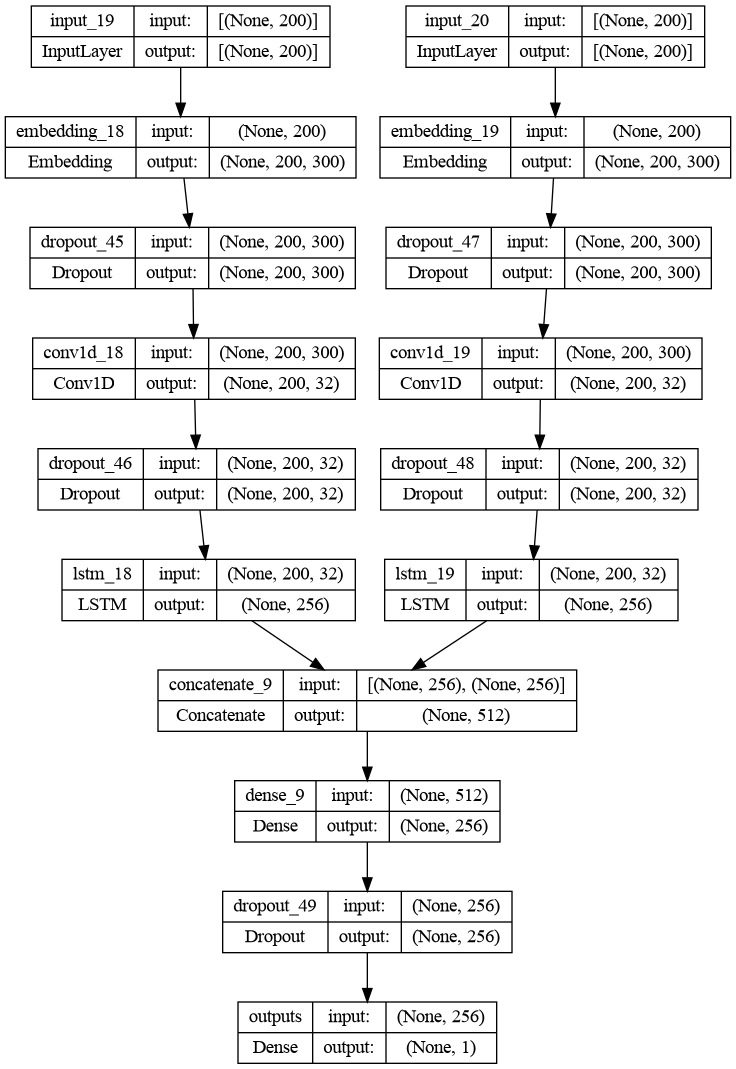

In [132]:
import keras
keras.utils.plot_model(model, "final_model.png", show_shapes=True)